# Interchange Interventions Tutorial: Cross-Patching for Entity Binding

This notebook is a comprehensive tutorial on **interchange interventions** for entity binding tasks. We focus on the **Binding Address + Payload** experiment, which tests whether entity binding information can be transferred by cross-patching activations between different token positions.

## Prerequisites

You should have completed:
- **01_task_and_causal_model.ipynb**: Core data structures, templates, causal model basics
- **02_token_positions.ipynb**: Token position functions, mega template system
- **03_counterfactuals_and_positional_variables.ipynb**: Counterfactual generation, `swap_query_group`

## What is an Interchange Intervention?

An **interchange intervention** is a technique from causal abstraction where we:
1. Run the model on an **original** input and cache activations at specific locations
2. Run the model on a **counterfactual** input and cache activations at (potentially different) locations
3. Run the model on the original input again, but **patch in** the counterfactual's activations
4. Check if the output changes in the way the causal model predicts

If the patched output matches what the causal model predicts, this provides evidence that the targeted neural components implement the causal variable we're testing.

## The Experiment: Binding Address + Payload

We test a specific hypothesis about how models represent entity bindings. The key idea is:

**Hypothesis**: Entity binding information at a token position contains both:
- **Address**: Which position/group this entity belongs to
- **Payload**: What the entity actually is

If this is true, we should be able to **transfer** binding information by cross-patching activations between positions where the same entities appear in different configurations.

## The Cross-Patching Setup

With `swap_query_group(change_answer=False)`:

| | Original | Counterfactual |
|---|---|---|
| **Prompt** | "Pete loves pie and Ann loves cake. Who loves pie?" | "Ann loves cake and Pete loves pie. Who loves pie?" |
| **Answer** | "Pete" | "Pete" (same!) |
| **g0** | (Pete, pie) | (Ann, cake) |
| **g1** | (Ann, cake) | (Pete, pie) |

Both prompts have the **same answer** ("Pete"), but the entities are at **different positions**.

### The Cross-Patching Intervention

We patch activations using **swapped** token positions:

```
Original positions:       [g0_e0, g0_e1, g1_e0, g1_e1]  → where Pete, pie, Ann, cake are
Counterfactual positions: [g1_e0, g1_e1, g0_e0, g0_e1]  → where Pete, pie, Ann, cake are (swapped!)
```

**Concretely**: We take the activation where "Pete" appears in the counterfactual (at g1_e0) and patch it to where "Ann" appears in the original (at g0_e0). We do this for all 4 entity positions simultaneously.

### What Does Success Mean?

If the intervention succeeds (model still outputs the correct answer), it shows that:
1. The binding information at those positions is **transferable**
2. The model's entity binding mechanism works via activations that encode both "address" and "payload" together

The target variables use the `<-` notation to indicate cross-intervention:
- `positional_entity_g0_e0<-positional_entity_g1_e0`: Patch g0_e0 from counterfactual's g1_e0

---
## Part 1: Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from pathlib import Path
import tempfile

# Task-specific imports
from causalab.tasks.entity_binding.causal_models import create_positional_entity_causal_model
from causalab.tasks.entity_binding.counterfactuals import swap_query_group
from causalab.tasks.entity_binding.experiment_config import get_task_config, get_checker
from causalab.tasks.entity_binding.token_positions import get_entity_token_positions

# Experiment infrastructure
from causalab.causal.causal_utils import generate_counterfactual_samples, save_counterfactual_examples
from causalab.experiments.filter import filter_dataset
from causalab.experiments.interchange_targets import build_residual_stream_targets
from causalab.experiments.jobs.interchange_score_grid import run_interchange_score_heatmap

# Neural network utilities
from causalab.neural.pipeline import LMPipeline
from causalab.neural.token_position_builder import (
    TokenPosition,
    paired_token_position,
    combined_token_position,
)

In [2]:
# Experiment configuration
EXPERIMENT_CONFIG = {
    "model_name": "Qwen/Qwen3-8B",
    "config_name": "love",
    "query_indices": (1,),      # Query food: "Who loves {food}?"
    "answer_index": 0,          # Answer is person
    "change_answer": False,     # KEY: Counterfactual has SAME answer (just swapped positions)
    "dataset_size": 128,
    "batch_size": 32,
}

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if device == "cuda" else torch.float32

print(f"Device: {device}")
print(f"Dtype: {dtype}")
print(f"\nKey setting: change_answer={EXPERIMENT_CONFIG['change_answer']}")
print("This means original and counterfactual have the SAME answer but different entity positions.")

Device: cuda
Dtype: torch.bfloat16

Key setting: change_answer=False
This means original and counterfactual have the SAME answer but different entity positions.


In [3]:
# Load the language model
print(f"Loading {EXPERIMENT_CONFIG['model_name']}...")

pipeline = LMPipeline(
    EXPERIMENT_CONFIG["model_name"],
    max_new_tokens=5,
    device=device,
    dtype=dtype,
    max_length=256,
)
pipeline.tokenizer.padding_side = "left"

num_layers = pipeline.model.config.num_hidden_layers
print(f"Model loaded with {num_layers} layers")

Loading Qwen/Qwen3-8B...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model loaded with 36 layers


In [4]:
# Create task config and causal model
task_config = get_task_config(EXPERIMENT_CONFIG["config_name"])
task_config.fixed_query_indices = EXPERIMENT_CONFIG["query_indices"]
task_config.fixed_answer_index = EXPERIMENT_CONFIG["answer_index"]

causal_model = create_positional_entity_causal_model(task_config)

print(f"Causal model: {causal_model.id}")
print(f"Total variables: {len(causal_model.variables)}")
print(f"\nPositional entity variables (the ones we'll cross-patch):")
for v in causal_model.variables:
    if v.startswith("positional_entity_"):
        print(f"  - {v}")

Causal model: entity_binding_positional_entity_2g_2e
Total variables: 22

Positional entity variables (the ones we'll cross-patch):
  - positional_entity_g0_e0
  - positional_entity_g0_e1
  - positional_entity_g1_e0
  - positional_entity_g1_e1


---
## Part 2: Generate Counterfactual Dataset

We use `swap_query_group` with `change_answer=False` to create counterfactual pairs where:
- Entity groups are **swapped** between positions
- The **answer stays the same** (both prompts ask about the same food, answered by the same person)

This is crucial for the cross-patching experiment because we want to test whether binding information can transfer between positions that have the *same* answer but *different* entity configurations.

In [5]:
# Generate counterfactual dataset
def generator():
    return swap_query_group(task_config, change_answer=EXPERIMENT_CONFIG["change_answer"])

dataset = generate_counterfactual_samples(EXPERIMENT_CONFIG["dataset_size"], generator)
print(f"Generated {len(dataset)} counterfactual pairs")

Generated 128 counterfactual pairs


In [6]:
# Show an example pair with detailed breakdown
example = dataset[0]
input_sample = example["input"]
cf_sample = example["counterfactual_inputs"][0]

print("=" * 70)
print("ORIGINAL INPUT")
print("=" * 70)
print(f"Prompt: {input_sample['raw_input']}")
print(f"\nExpected Answer: {input_sample['raw_output']}")
print(f"Query group: {input_sample['query_group']}")
print(f"positional_answer: {input_sample['positional_answer']}")

print("\n" + "=" * 70)
print("COUNTERFACTUAL")
print("=" * 70)
print(f"Prompt: {cf_sample['raw_input']}")
print(f"\nExpected Answer: {cf_sample['raw_output']}")
print(f"Query group: {cf_sample['query_group']}")
print(f"positional_answer: {cf_sample['positional_answer']}")

ORIGINAL INPUT
Prompt: We will ask a question about the following sentences.

Sue loves jam and Kate loves bread.

Who loves bread?
Answer:

Expected Answer: Kate
Query group: 1
positional_answer: 1

COUNTERFACTUAL
Prompt: We will ask a question about the following sentences.

Kate loves bread and Sue loves jam.

Who loves bread?
Answer:

Expected Answer: Kate
Query group: 0
positional_answer: 0


In [7]:
# Verify that the answer is the SAME but positions are SWAPPED
print("VERIFICATION: Same answer, different positions")
print("=" * 70)
print(f"\nAnswer comparison:")
print(f"  Original answer: {input_sample['raw_output']}")
print(f"  Counterfactual answer: {cf_sample['raw_output']}")
print(f"  Same? {input_sample['raw_output'] == cf_sample['raw_output']}")

print(f"\nEntity positions (showing the SWAP):")
print(f"{'Position':<15} {'Original':<20} {'Counterfactual':<20} {'Swapped?'}")
print("-" * 70)
for g in range(input_sample['active_groups']):
    for e in range(input_sample['entities_per_group']):
        key = f"entity_g{g}_e{e}"
        input_val = input_sample.get(key)
        cf_val = cf_sample.get(key)
        swapped = "YES" if input_val != cf_val else "no"
        print(f"{key:<15} {str(input_val):<20} {str(cf_val):<20} {swapped}")

VERIFICATION: Same answer, different positions

Answer comparison:
  Original answer: Kate
  Counterfactual answer: Kate
  Same? True

Entity positions (showing the SWAP):
Position        Original             Counterfactual       Swapped?
----------------------------------------------------------------------
entity_g0_e0    Sue                  Kate                 YES
entity_g0_e1    jam                  bread                YES
entity_g1_e0    Kate                 Sue                  YES
entity_g1_e1    bread                jam                  YES


### Interpretation

Notice that:
1. The **answer is the same** in both prompts (e.g., "Pete")
2. The **entity positions are swapped**: what was at g0 is now at g1 and vice versa
3. This creates the perfect setup for cross-patching: we can test if binding information at one position can be "transferred" to another position where the same entity now appears

---
## Part 3: Token Positions for Cross-Patching

This is the core of the cross-patching experiment. We need to create **paired token positions** that specify:
- **Original positions**: Where to read/write in the original input
- **Counterfactual positions**: Where to read from in the counterfactual input (swapped!)

The key insight is that when we patch, we want to:
- Take activation from **g1_e0** in counterfactual → patch into **g0_e0** in original
- Take activation from **g1_e1** in counterfactual → patch into **g0_e1** in original
- Take activation from **g0_e0** in counterfactual → patch into **g1_e0** in original
- Take activation from **g0_e1** in counterfactual → patch into **g1_e1** in original

In [8]:
# Helper function to fix query_indices serialization
def _fix_query_indices(input_sample):
    """Convert query_indices from list to tuple if needed (HuggingFace serialization fix)."""
    if hasattr(input_sample, "to_dict"):
        sample = input_sample.to_dict()
    else:
        sample = dict(input_sample)
    if isinstance(sample.get("query_indices"), list):
        sample["query_indices"] = tuple(sample["query_indices"])
    return sample

In [9]:
# Create indexer functions for each entity position
# These functions return the token indices for a specific entity in the prompt

def make_entity_indexer(group_idx: int, entity_idx: int):
    """Create an indexer function that finds the last token of an entity."""
    def indexer(input_sample, is_original=True):
        sample = _fix_query_indices(input_sample)
        return get_entity_token_positions(
            input_sample=sample,
            pipeline=pipeline,
            config=task_config,
            group_idx=group_idx,
            entity_idx=entity_idx,
            token_idx=-1,  # Last token of the entity
        )
    return indexer

# Build individual token positions for all 4 entities
g0_e0_pos = TokenPosition(make_entity_indexer(0, 0), pipeline, id="g0_e0_last")
g0_e1_pos = TokenPosition(make_entity_indexer(0, 1), pipeline, id="g0_e1_last")
g1_e0_pos = TokenPosition(make_entity_indexer(1, 0), pipeline, id="g1_e0_last")
g1_e1_pos = TokenPosition(make_entity_indexer(1, 1), pipeline, id="g1_e1_last")

print("Created individual token positions:")
print(f"  g0_e0_pos: Last token of entity at group 0, position 0 (person0)")
print(f"  g0_e1_pos: Last token of entity at group 0, position 1 (food0)")
print(f"  g1_e0_pos: Last token of entity at group 1, position 0 (person1)")
print(f"  g1_e1_pos: Last token of entity at group 1, position 1 (food1)")

Created individual token positions:
  g0_e0_pos: Last token of entity at group 0, position 0 (person0)
  g0_e1_pos: Last token of entity at group 0, position 1 (food0)
  g1_e0_pos: Last token of entity at group 1, position 0 (person1)
  g1_e1_pos: Last token of entity at group 1, position 1 (food1)


In [10]:
# Create COMBINED positions for original and counterfactual
# Original order: [g0_e0, g0_e1, g1_e0, g1_e1]
original_combined = combined_token_position(
    [g0_e0_pos, g0_e1_pos, g1_e0_pos, g1_e1_pos], 
    id="g0_g1"
)

# Counterfactual order: [g1_e0, g1_e1, g0_e0, g0_e1] (SWAPPED!)
counterfactual_combined = combined_token_position(
    [g1_e0_pos, g1_e1_pos, g0_e0_pos, g0_e1_pos], 
    id="g1_g0"
)

print("Created combined token positions:")
print(f"\nOriginal order (g0_g1):")
print(f"  [g0_e0, g0_e1, g1_e0, g1_e1]")
print(f"\nCounterfactual order (g1_g0):")
print(f"  [g1_e0, g1_e1, g0_e0, g0_e1]")
print(f"\nThis means when we patch:")
print(f"  - g0_e0 in original ← g1_e0 in counterfactual")
print(f"  - g0_e1 in original ← g1_e1 in counterfactual")
print(f"  - g1_e0 in original ← g0_e0 in counterfactual")
print(f"  - g1_e1 in original ← g0_e1 in counterfactual")

Created combined token positions:

Original order (g0_g1):
  [g0_e0, g0_e1, g1_e0, g1_e1]

Counterfactual order (g1_g0):
  [g1_e0, g1_e1, g0_e0, g0_e1]

This means when we patch:
  - g0_e0 in original ← g1_e0 in counterfactual
  - g0_e1 in original ← g1_e1 in counterfactual
  - g1_e0 in original ← g0_e0 in counterfactual
  - g1_e1 in original ← g0_e1 in counterfactual


In [11]:
# Create the PAIRED token position for cross-patching
# This is the key: it uses DIFFERENT positions for original vs counterfactual
cross_patch_position = paired_token_position(
    original_combined, 
    counterfactual_combined, 
    id="group_swap"
)

print("Created paired token position for cross-patching:")
print(f"  ID: {cross_patch_position.id}")
print(f"\nThis position automatically:")
print(f"  - Uses 'g0_g1' order when called with is_original=True")
print(f"  - Uses 'g1_g0' order when called with is_original=False (counterfactual)")

Created paired token position for cross-patching:
  ID: group_swap

This position automatically:
  - Uses 'g0_g1' order when called with is_original=True
  - Uses 'g1_g0' order when called with is_original=False (counterfactual)


In [12]:
# Verify the token positions work correctly on our example
print("Verifying token positions on example...")
print("=" * 70)

# Get positions for original
orig_positions = cross_patch_position.index(input_sample, is_original=True)
cf_positions = cross_patch_position.index(cf_sample, is_original=False)

print(f"\nOriginal input token positions: {orig_positions}")
print(f"Counterfactual input token positions: {cf_positions}")

# Show what tokens these correspond to
# Note: use add_special_tokens=True to match how pipeline.load() tokenizes
orig_tokens = pipeline.tokenizer.encode(input_sample['raw_input'], add_special_tokens=True)
cf_tokens = pipeline.tokenizer.encode(cf_sample['raw_input'], add_special_tokens=True)

print(f"\nTotal tokens in original: {len(orig_tokens)}")
print(f"Total tokens in counterfactual: {len(cf_tokens)}")

print(f"\nOriginal tokens at those positions:")
for i, pos in enumerate(orig_positions):
    if pos < len(orig_tokens):
        token = pipeline.tokenizer.decode([orig_tokens[pos]])
        print(f"  Position {pos}: '{token}'")
    else:
        print(f"  Position {pos}: (out of range)")

print(f"\nCounterfactual tokens at those positions:")
for i, pos in enumerate(cf_positions):
    if pos < len(cf_tokens):
        token = pipeline.tokenizer.decode([cf_tokens[pos]])
        print(f"  Position {pos}: '{token}'")

Verifying token positions on example...

Original input token positions: [242, 244, 246, 248]
Counterfactual input token positions: [246, 248, 242, 244]

Total tokens in original: 25
Total tokens in counterfactual: 24

Original tokens at those positions:
  Position 242: (out of range)
  Position 244: (out of range)
  Position 246: (out of range)
  Position 248: (out of range)

Counterfactual tokens at those positions:


---
## Part 4: Filter Dataset

We filter the dataset to keep only examples where the neural model **agrees** with the causal model. This ensures we're testing on examples where the model correctly performs the entity binding task.

Filtering is important because if the model gets an example wrong, we can't meaningfully test whether our intervention changes the output as the causal model predicts.

In [13]:
# Filter dataset for model-causal agreement
checker = get_checker()

print("Filtering dataset for model-causal agreement...")
print("This checks that the model's output matches the causal model's expected output.")

filtered_dataset = filter_dataset(
    dataset=dataset,
    pipeline=pipeline,
    causal_model=causal_model,
    metric=checker,
    batch_size=EXPERIMENT_CONFIG["batch_size"],
)

keep_rate = len(filtered_dataset) / len(dataset) * 100
print(f"\nFiltering results:")
print(f"  Original: {len(dataset)} examples")
print(f"  Filtered: {len(filtered_dataset)} examples")
print(f"  Keep rate: {keep_rate:.1f}%")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Filtering dataset for model-causal agreement...
This checks that the model's output matches the causal model's expected output.

Filtering results:
  Original: 128 examples
  Filtered: 128 examples
  Keep rate: 100.0%


In [14]:
# Save filtered dataset to temp directory
temp_dir = Path(tempfile.mkdtemp())
datasets_dir = temp_dir / "datasets"
results_dir = temp_dir / "results"
datasets_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

filtered_path = datasets_dir / "filtered_dataset.json"
save_counterfactual_examples(filtered_dataset, str(filtered_path))

print(f"Saved filtered dataset to: {filtered_path}")
print(f"Results will be saved to: {results_dir}")

Saved filtered dataset to: /tmp/tmps0btnta_/datasets/filtered_dataset.json
Results will be saved to: /tmp/tmps0btnta_/results


---
## Part 5: Build Interchange Targets

**Interchange targets** specify where in the model to perform interventions. We target the **residual stream** at our cross-patching token positions across all layers.

The residual stream is the "main pathway" through the transformer - the accumulated sum of embeddings, attention outputs, and MLP outputs. By patching the residual stream from a counterfactual run, we can test what information is represented at different layers.

In [15]:
# The token position we'll use for cross-patching
token_positions = [cross_patch_position]

# Build interchange targets for all layers
# -1 represents the embeddings layer
layers = [-1] + list(range(num_layers))

targets = build_residual_stream_targets(
    pipeline=pipeline,
    layers=layers,
    token_positions=token_positions,
    mode="one_target_per_unit",
)

print(f"Built {len(targets)} interchange targets")
print(f"Layers: embedding (-1) + {num_layers} transformer layers")
print(f"Token position: {cross_patch_position.id}")
print(f"\nSample target keys: {list(targets.keys())[:5]}...")

Built 37 interchange targets
Layers: embedding (-1) + 36 transformer layers
Token position: group_swap

Sample target keys: [(-1, 'group_swap'), (0, 'group_swap'), (1, 'group_swap'), (2, 'group_swap'), (3, 'group_swap')]...


In [16]:
# Inspect what variables we're targeting with cross-intervention
target_variables = [
    "positional_entity_g0_e0<-positional_entity_g1_e0",
    "positional_entity_g0_e1<-positional_entity_g1_e1",
    "positional_entity_g1_e0<-positional_entity_g0_e0",
    "positional_entity_g1_e1<-positional_entity_g0_e1",
]

print("Target variables with cross-intervention notation:")
print("=" * 70)
for var in target_variables:
    original_var, cf_var = var.split("<-")
    print(f"\n{var}")
    print(f"  → Patch {original_var} in original")
    print(f"  ← Using value from {cf_var} in counterfactual")

print("\n" + "=" * 70)
print("\nThe '<-' syntax tells the causal model to evaluate the original input")
print("as if the variable on the left had the value from the counterfactual's")
print("variable on the right.")

Target variables with cross-intervention notation:

positional_entity_g0_e0<-positional_entity_g1_e0
  → Patch positional_entity_g0_e0 in original
  ← Using value from positional_entity_g1_e0 in counterfactual

positional_entity_g0_e1<-positional_entity_g1_e1
  → Patch positional_entity_g0_e1 in original
  ← Using value from positional_entity_g1_e1 in counterfactual

positional_entity_g1_e0<-positional_entity_g0_e0
  → Patch positional_entity_g1_e0 in original
  ← Using value from positional_entity_g0_e0 in counterfactual

positional_entity_g1_e1<-positional_entity_g0_e1
  → Patch positional_entity_g1_e1 in original
  ← Using value from positional_entity_g0_e1 in counterfactual


The '<-' syntax tells the causal model to evaluate the original input
as if the variable on the left had the value from the counterfactual's
variable on the right.


---
## Part 6: Run the Experiment

Now we run the full interchange intervention experiment. For each layer, we:

1. **Cache activations**: Run the model on original and counterfactual, caching residual stream at the target layer
2. **Patch**: Run the model on original again, but replace the residual stream at the cross-patch positions with values from the counterfactual
3. **Evaluate**: Check if the output matches what the causal model predicts for this intervention

The **interchange score** measures how well the patching transfers the causal variable:
- Score = 1.0: Perfect transfer - the intervention produces exactly the predicted output
- Score = 0.0: No effect - the intervention doesn't change the output as expected

Running interchange interventions...

Configuration:
  Dataset size: 128
  Batch size: 32
  Layers: 37 (embedding + 36 transformer)
  Token position: group_swap
  Target variables: 4 cross-intervention variables



Running interventions: 100%|██████████| 37/37 [01:51<00:00,  3.00s/it]


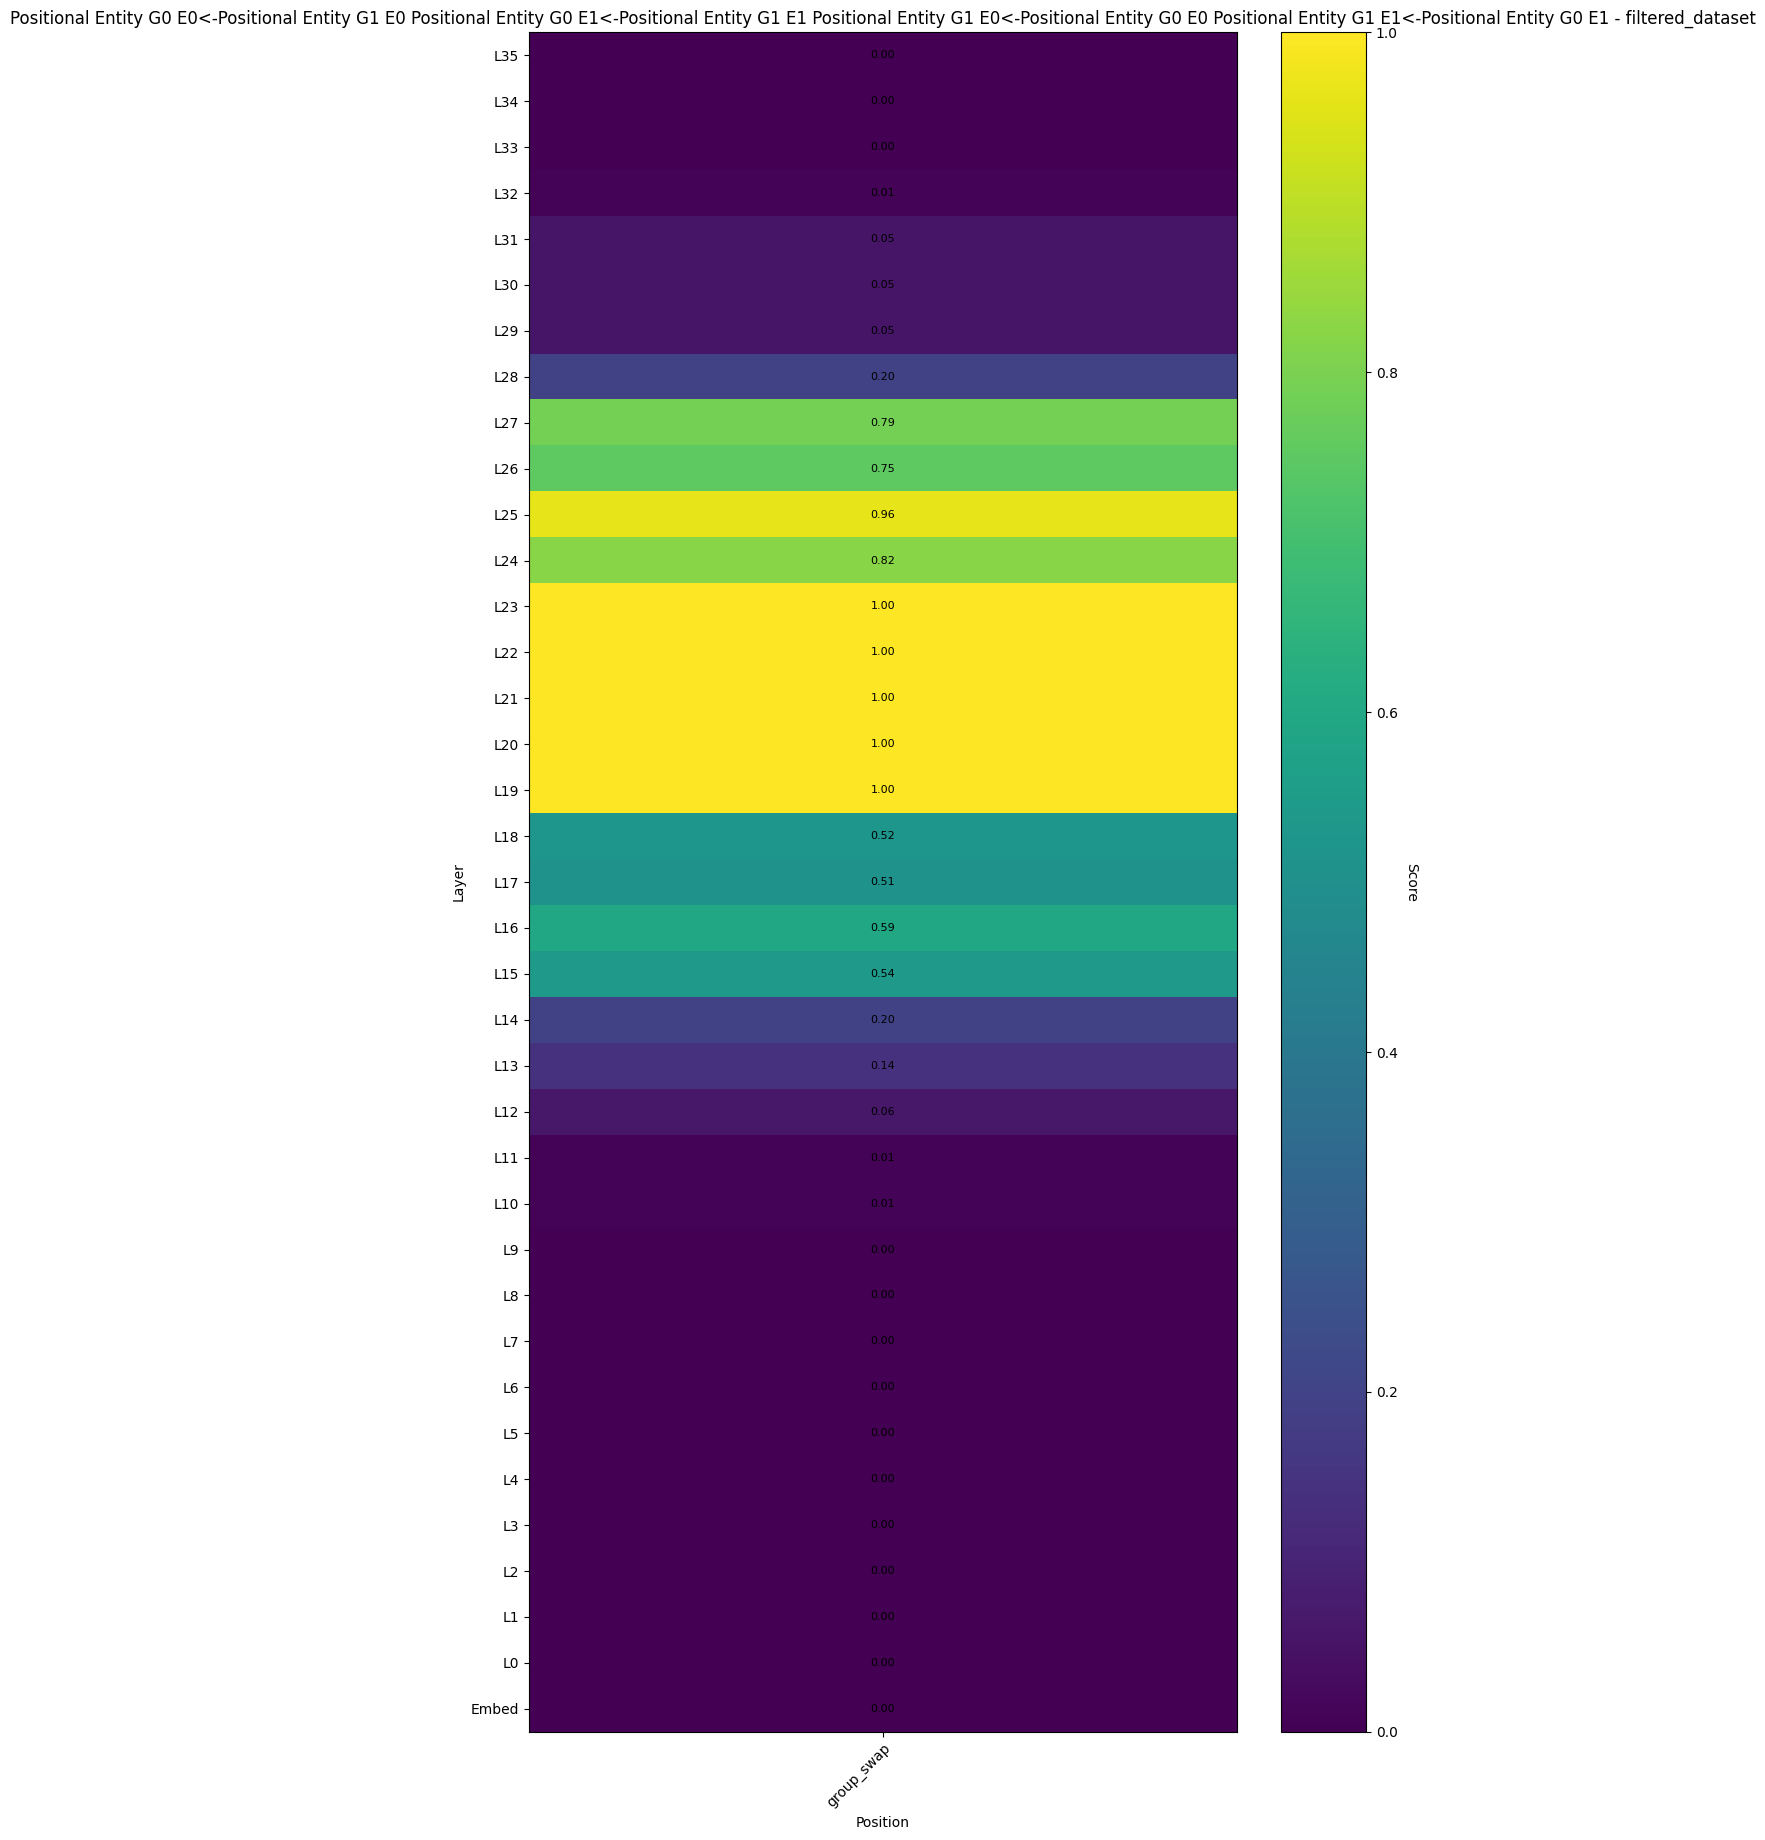

In [17]:
# Target variable groups for the experiment
# We use tuples because we're intervening on multiple variables simultaneously
target_variable_groups = [tuple(target_variables)]

print("Running interchange interventions...")
print(f"\nConfiguration:")
print(f"  Dataset size: {len(filtered_dataset)}")
print(f"  Batch size: {EXPERIMENT_CONFIG['batch_size']}")
print(f"  Layers: {len(layers)} (embedding + {num_layers} transformer)")
print(f"  Token position: {cross_patch_position.id}")
print(f"  Target variables: {len(target_variables)} cross-intervention variables")
print()

result = run_interchange_score_heatmap(
    causal_model=causal_model,
    interchange_targets=targets,
    dataset_path=str(filtered_path),
    pipeline=pipeline,
    target_variable_groups=target_variable_groups,
    batch_size=EXPERIMENT_CONFIG["batch_size"],
    output_dir=str(results_dir),
    metric=checker,
    verbose=True,
)

---
## Part 7: Results and Interpretation

Let's visualize and interpret the results. The heatmap shows the interchange score at each layer - higher scores indicate that patching at that layer successfully transfers the binding information.

In [18]:
# Display results summary
print("Experiment Results")
print("=" * 70)

if "scores" in result:
    for var_group, scores in result["scores"].items():
        print(f"\nVariable group: {var_group}")
        
        # Extract scores by layer
        layer_scores = {}
        for key, score in scores.items():
            # Key format is (layer, position_id)
            layer = key[0]
            layer_scores[layer] = score
        
        # Find best layers
        sorted_layers = sorted(layer_scores.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\n  Top 5 layers by interchange score:")
        for layer, score in sorted_layers[:5]:
            layer_name = "embedding" if layer == -1 else f"layer {layer}"
            print(f"    {layer_name}: {score:.3f}")
        
        print(f"\n  Bottom 5 layers by interchange score:")
        for layer, score in sorted_layers[-5:]:
            layer_name = "embedding" if layer == -1 else f"layer {layer}"
            print(f"    {layer_name}: {score:.3f}")
        
        avg_score = sum(layer_scores.values()) / len(layer_scores)
        print(f"\n  Average score across all layers: {avg_score:.3f}")

Experiment Results

Variable group: ('positional_entity_g0_e0<-positional_entity_g1_e0', 'positional_entity_g0_e1<-positional_entity_g1_e1', 'positional_entity_g1_e0<-positional_entity_g0_e0', 'positional_entity_g1_e1<-positional_entity_g0_e1')

  Top 5 layers by interchange score:
    layer 19: 1.000
    layer 20: 1.000
    layer 21: 1.000
    layer 22: 1.000
    layer 23: 1.000

  Bottom 5 layers by interchange score:
    layer 8: 0.000
    layer 9: 0.000
    layer 33: 0.000
    layer 34: 0.000
    layer 35: 0.000

  Average score across all layers: 0.304


Saved heatmaps:

filtered_dataset_positional_entity_g0_e0<-positional_entity_g1_e0_positional_entity_g0_e1<-positional_entity_g1_e1_positional_entity_g1_e0<-positional_entity_g0_e0_positional_entity_g1_e1<-positional_entity_g0_e1.png:


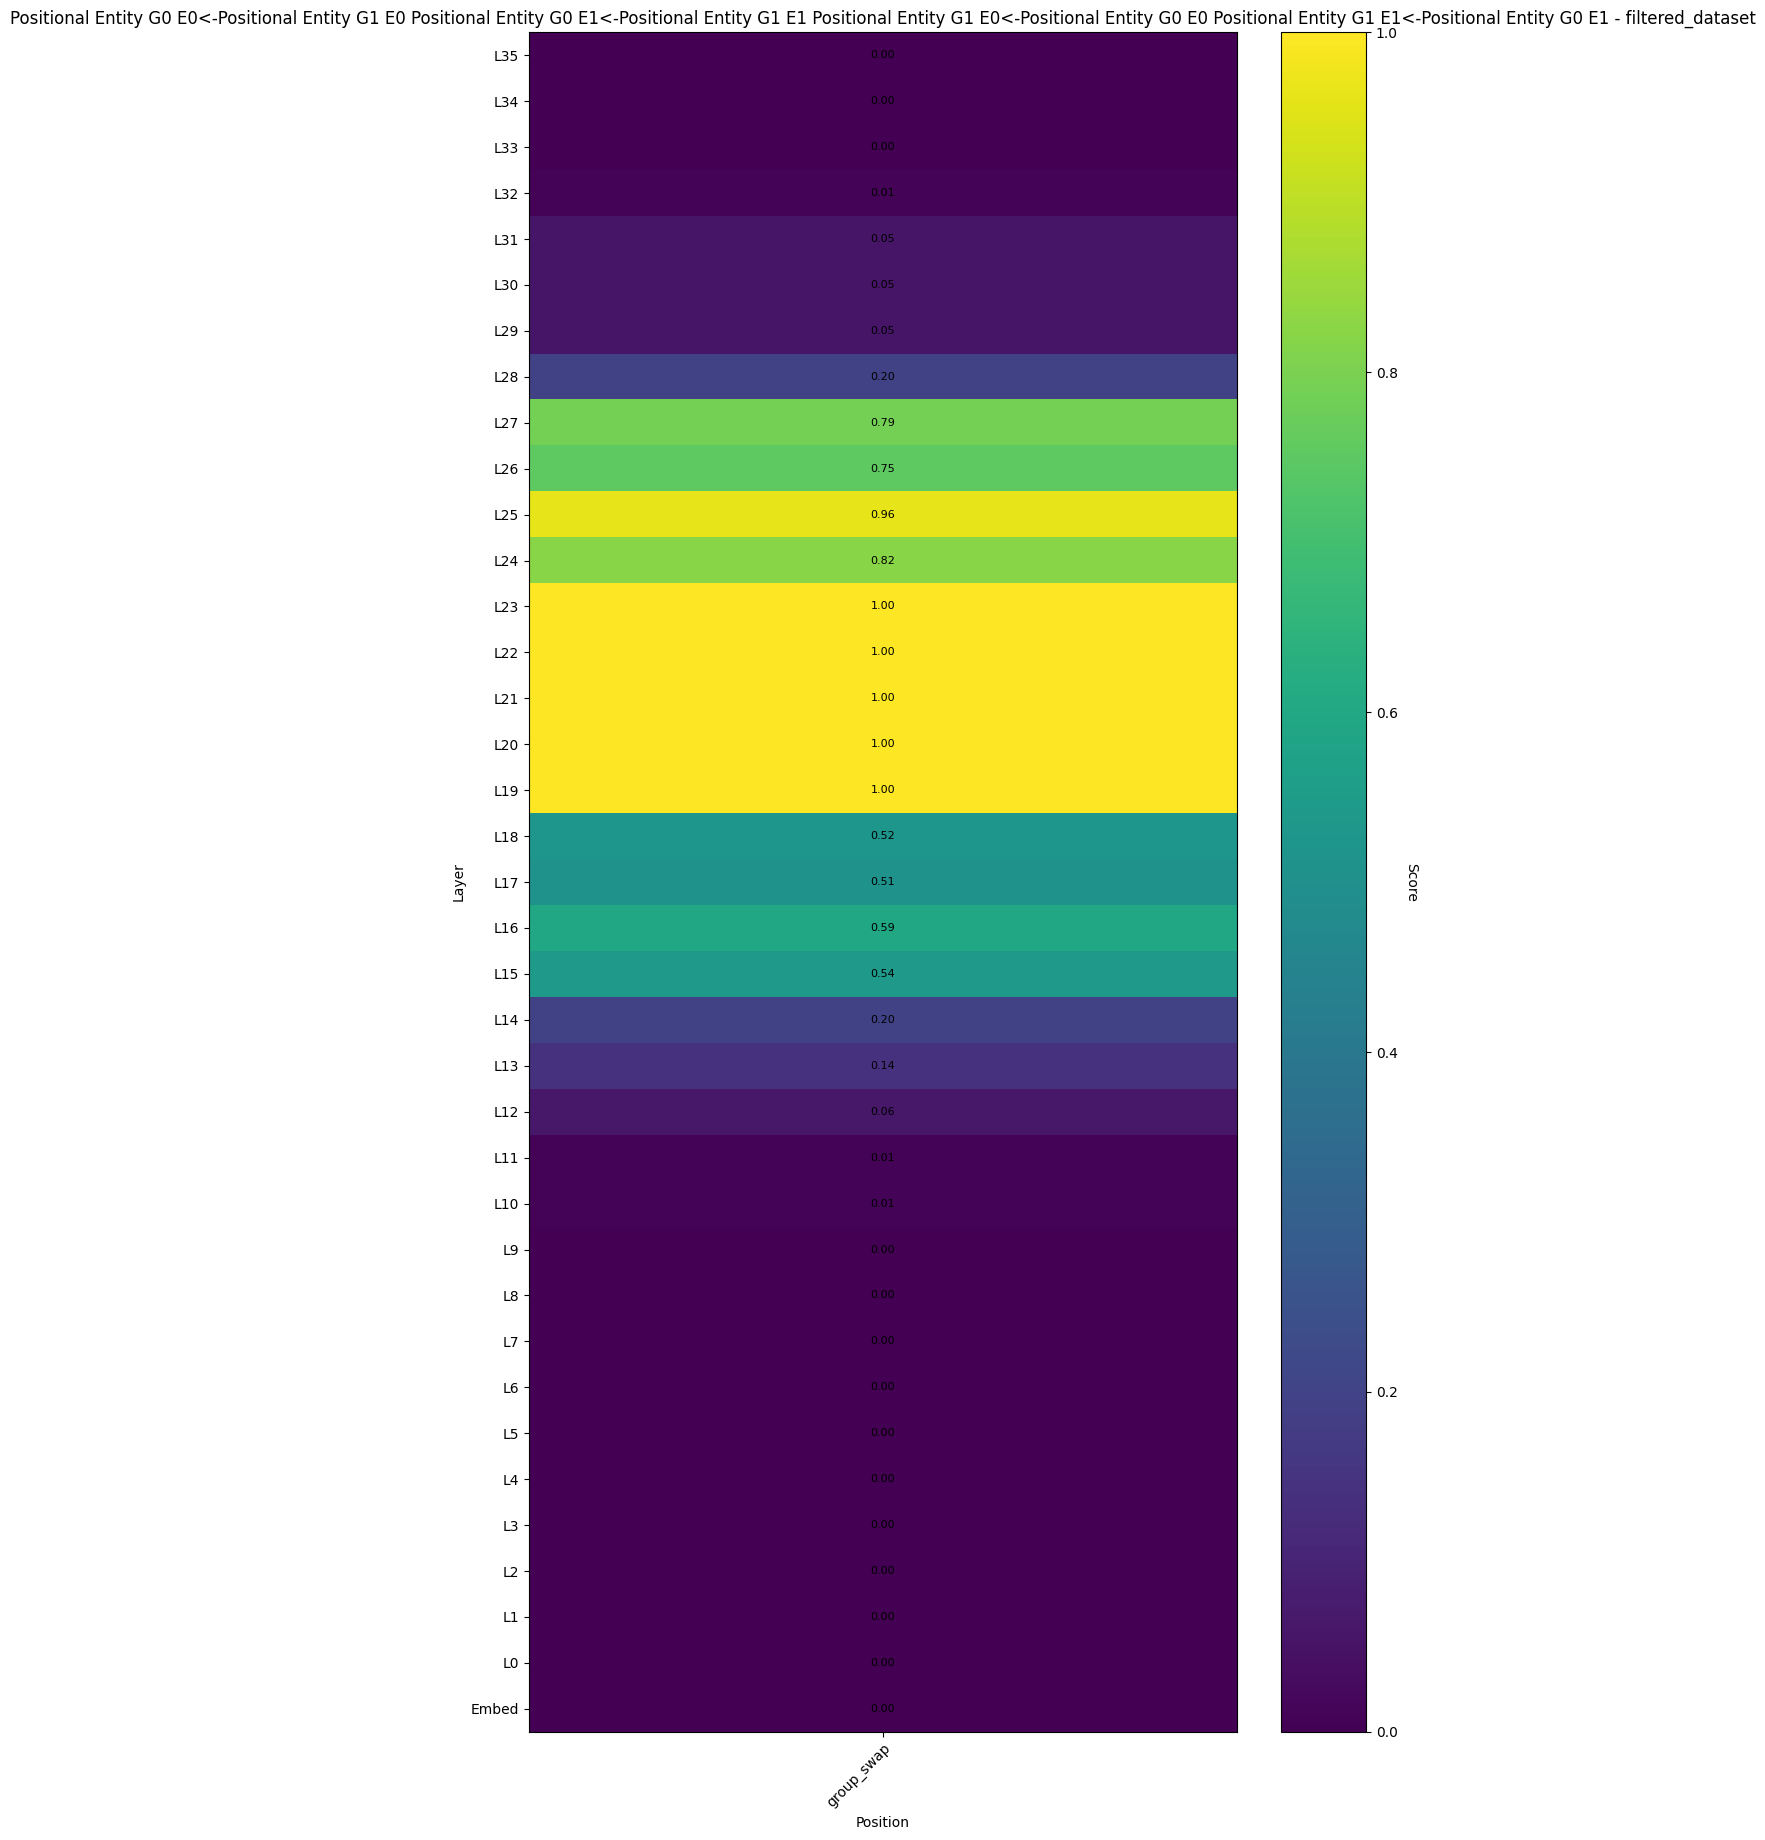

In [20]:
# Show saved heatmaps if available
heatmap_dir = results_dir / "heatmaps"
if heatmap_dir.exists():
    from IPython.display import Image, display
    
    print("Saved heatmaps:")
    for heatmap_file in sorted(heatmap_dir.glob("*.png")):
        print(f"\n{heatmap_file.name}:")
        display(Image(filename=str(heatmap_file)))

---
## Part 8: Interpretation

### What the Results Tell Us

The interchange scores reveal **where** entity binding information is localized in the model:

1. **Low scores in early layers**: Embedding and early attention layers don't yet contain transferable binding information. The model hasn't "computed" the entity bindings yet.

2. **Peak scores in middle layers**: This is where entity binding information is most "ripe" for transfer. The model has computed which entities are bound together, and this information is represented in a form that can be cross-patched.

3. **Declining scores in late layers**: By the final layers, the model has started converting binding information into the specific output token. The representation becomes too specialized to transfer.

### The Binding Address + Payload Hypothesis

If cross-patching succeeds (high interchange scores), this supports the hypothesis that:

- Entity binding information is represented as a combination of **address** (positional/structural information about where entities are) and **payload** (the actual entity values)
- This combined representation can be **transferred** between positions
- The model's entity binding mechanism is fundamentally about associating positions with values in a way that's portable

### Comparison with Notebook 04

In notebook 04, we used `change_answer=True`, which tests a different hypothesis:
- There, we're asking whether patching changes the output from one answer to another
- Here (with `change_answer=False`), we're asking whether patching can maintain the correct answer despite position swaps

Both experiments together give us a more complete picture of how entity binding works in the model.

---
## Part 9: Summary and Key Takeaways

### What We Did

1. **Created counterfactual pairs** where entities swap positions but the answer stays the same
2. **Built cross-patching token positions** that map original positions to swapped counterfactual positions
3. **Ran interchange interventions** at all layers of the model
4. **Measured interchange scores** to identify where binding information is transferable

### Key Concepts Covered

- **Interchange interventions**: Patching activations from counterfactual into original to test causal hypotheses
- **Paired token positions**: Specifying different positions for original vs counterfactual in cross-patching
- **Combined token positions**: Grouping multiple positions for simultaneous intervention
- **Cross-intervention notation** (`A<-B`): Specifying that variable A should receive B's value from the counterfactual

### Causal Abstraction Methodology

This experiment demonstrates the power of **causal abstraction** for interpretability:

1. **Define a causal model** that describes how the task *should* be solved (positional entity model)
2. **Create interventions** that test whether neural components implement specific causal variables
3. **Measure alignment** between neural behavior and causal model predictions
4. **Interpret results** to understand what the neural network has learned

### Extensions

Ideas for further exploration:

- Test with different models to see if the layer localization pattern is consistent
- Try intervening on attention heads or MLP layers instead of the full residual stream
- Compare results between `change_answer=True` and `change_answer=False` systematically
- Test with 3-group configurations to see if the pattern scales

In [21]:
# Cleanup
print(f"\nResults saved to: {results_dir}")
print(f"Dataset saved to: {datasets_dir}")
print(f"\nTo keep these results, copy them from the temp directory before the session ends.")


Results saved to: /tmp/tmps0btnta_/results
Dataset saved to: /tmp/tmps0btnta_/datasets

To keep these results, copy them from the temp directory before the session ends.
